<a href="https://colab.research.google.com/github/jamesjulius-02/K-Nearest-Neighbors-KNN-/blob/main/KNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Best Parameters from GridSearchCV: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Best Cross-Validation Score: 0.9428571428571428

Performance on Test Set
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Confusion Matrix:
 [[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


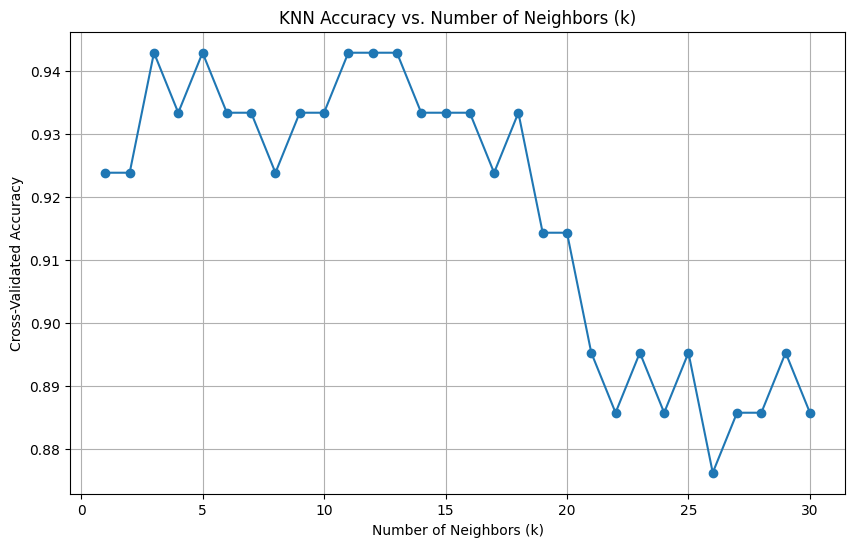

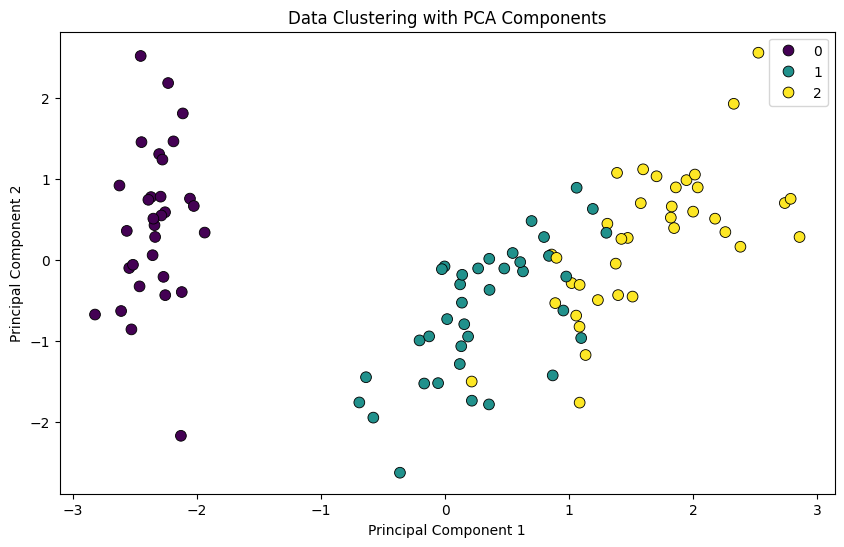

Silhouette Score: 0.37


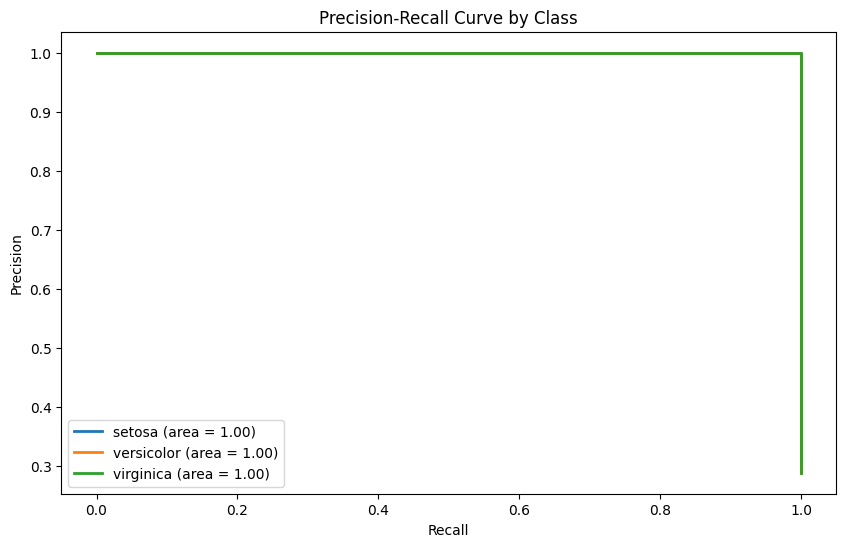

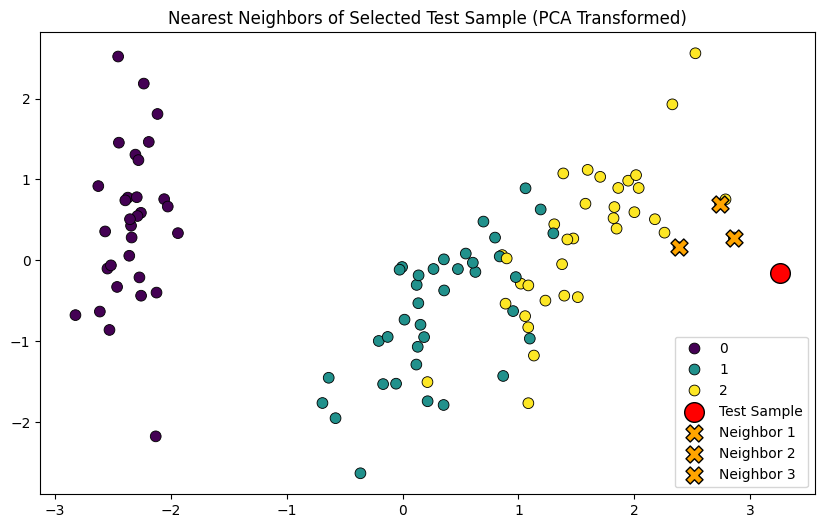

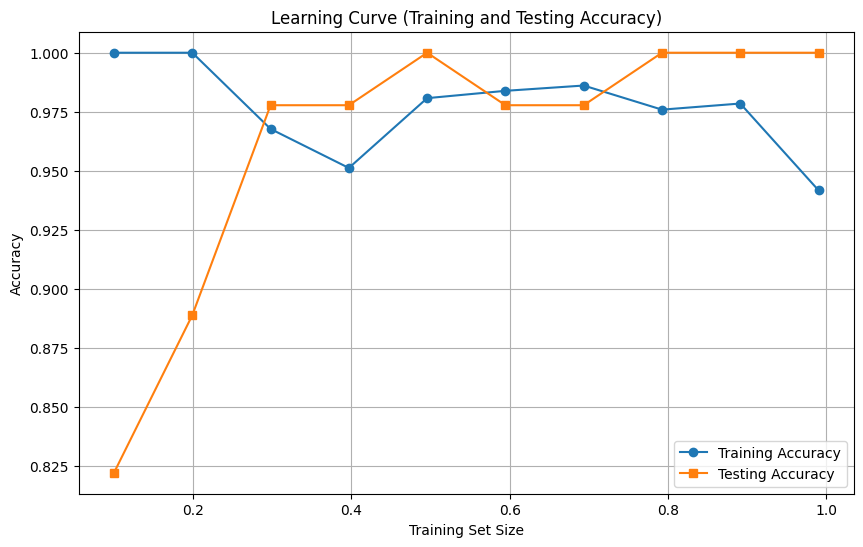

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from mpl_toolkits.mplot3d import Axes3D

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality Reduction with PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Hyperparameter Tuning
param_grid = {
    'n_neighbors': range(1, 31),
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Train the Best Model
best_knn = grid_search.best_estimator_
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

# Evaluation
print("\nPerformance on Test Set")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualization of Accuracy across k values
k_values = range(1, 31)
accuracies = [cross_val_score(KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='distance'),
                              X_train, y_train, cv=5).mean() for k in k_values]

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title("KNN Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True)
plt.show()

# Visualize Clusters with PCA (2D plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette="viridis", s=60, edgecolor="k")
plt.title("Data Clustering with PCA Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Silhouette Score to Analyze Clustering Effectiveness
silhouette_avg = silhouette_score(X_train, y_train)
print(f"Silhouette Score: {silhouette_avg:.2f}")

# Precision-Recall Analysis (especially for imbalanced classes)
y_probs = best_knn.predict_proba(X_test)
precision = {}
recall = {}
plt.figure(figsize=(10, 6))
for i in range(len(iris.target_names)):
    precision[i], recall[i], _ = precision_recall_curve((y_test == i).astype(int), y_probs[:, i])
    pr_auc = auc(recall[i], precision[i])
    plt.plot(recall[i], precision[i], lw=2, label=f'{iris.target_names[i]} (area = {pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve by Class")
plt.legend(loc="lower left")
plt.show()

# Visualize Nearest Neighbors of Selected Sample
sample_index = 2  # Change index to visualize different samples
sample = X_test[sample_index].reshape(1, -1)
neighbors = best_knn.kneighbors(sample, return_distance=False)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette="viridis", s=60, edgecolor="k")
sample_pca = pca.transform(sample)
plt.scatter(sample_pca[0, 0], sample_pca[0, 1], color="red", s=200, edgecolor="k", label="Test Sample")
for i, neighbor in enumerate(neighbors[0]):
    neighbor_pca = pca.transform(X_train[neighbor].reshape(1, -1))
    plt.scatter(neighbor_pca[0, 0], neighbor_pca[0, 1], color="orange", s=150, edgecolor="k", marker="X",
                label=f"Neighbor {i+1}")
plt.title("Nearest Neighbors of Selected Test Sample (PCA Transformed)")
plt.legend()
plt.show()

# Learning Curve Analysis
train_sizes = np.linspace(0.1, 0.99, 10)  # Adjust train_sizes to avoid 1.0
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_partial, _, y_train_partial, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
    best_knn.fit(X_train_partial, y_train_partial)
    train_scores.append(accuracy_score(y_train_partial, best_knn.predict(X_train_partial)))
    test_scores.append(accuracy_score(y_test, best_knn.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, label="Training Accuracy", marker="o")
plt.plot(train_sizes, test_scores, label="Testing Accuracy", marker="s")
plt.title("Learning Curve (Training and Testing Accuracy)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
